In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as sts
from scipy.special import ndtr
import scipy
import csv
import math

data = pd.read_csv('database_NEW.csv')
data.head()

cell_names = ["A","B","C","D","E","F","G","H"]

In [289]:
# Read training samples
pdata["SSID"] = pdata.SSID.fillna("")
SSIDs = pdata.SSID.unique()
    
# Remove temporary APs from default hotspot names of Android, iOS, and other vendors
SSIDs = pdata.SSID.unique()
filter_names = ["AndroidAP","iPhone", "Nokia", "OnePlus", "HUAWEI", "LG"]
to_remove = list()
for SSID in SSIDs:
    for name in filter_names:
        if name in SSID:
            to_remove.append(SSID)

for AP in to_remove:
    pdata = pdata.loc[data["SSID"] != AP]
    print(f"Temporary AP '{AP}' removed from dataset")
           
SSIDs = pdata.SSID.unique()
BSSIDs = pdata.BSSID.unique()

print(BSSIDs)

['b0:c2:87:e4:22:97' 'b2:c2:87:e4:22:98' '60:33:4b:e4:c5:69'
 'fc:ec:da:1a:0a:e9' '84:9c:a6:90:1f:88' 'fe:ec:da:1a:0a:e9'
 '6a:02:98:05:a1:fd' 'ae:22:15:23:8a:eb' 'ac:22:05:23:8a:eb'
 '6a:02:98:05:c5:14' 'f4:f2:6d:8c:8b:0c' '68:02:b8:05:a1:fd'
 '68:02:b8:05:c5:14' 'f6:57:40:94:e9:cc' '2a:35:d1:2b:3d:61'
 '38:d8:2f:0e:8f:0b' '48:d3:43:fd:59:19' 'ba:d5:26:e4:8c:71'
 '18:35:d1:2b:3d:61' '5a:d3:43:6c:63:b9' '48:d3:43:6c:63:b9'
 '36:2c:94:d4:1f:f6' '00:0c:f6:e4:2d:f2' '50:7e:5d:4a:ba:42'
 'ac:22:05:2b:83:59' '84:9c:a6:2a:dc:f5' '64:13:6c:2e:f9:f7'
 'c8:0e:14:4a:ec:06' '38:d8:2f:11:34:b0' '52:d8:2f:11:34:b1'
 'ae:22:15:88:6e:5d' '78:96:82:70:71:13' '72:30:d9:4f:94:b5'
 '5a:d3:43:d0:d4:69' 'e4:57:40:94:e9:cc' '24:a4:3c:ed:e9:d6'
 '5a:d3:43:fd:59:19' '62:96:82:70:a6:bd' '36:a4:3c:ed:e9:d6'
 '26:a4:3c:ed:e9:d6' '34:2c:c4:d4:1f:f6' 'e0:88:5d:8b:83:d6'
 '48:d3:43:d0:d4:69' '84:47:65:b2:a8:20' 'b8:d5:26:d4:8c:71'
 'ba:d5:26:d4:8c:71' '74:d0:2b:88:93:a0' 'ae:22:15:2b:83:59'
 '84:9c:a6:ad:0b:6c' '28

In [290]:
# TODO: apply filter / alpha-trimmer to account for gaps
# and probably more...
# A density plot is a smoothed, continuous version of a histogram estimated from the data. 
# The most common form of estimation is known as kernel density estimation. In this method, 
# a continuous curve (the kernel) is drawn at every individual data point and all of these 
# curves are then added together to make a single smooth density estimation. The kernel most 
# often used is a Gaussian (which produces a Gaussian bell curve at each data point). 
# https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

with open('data_to_phone.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    for AP in BSSIDs:
        filtered_BSSID = pdata.loc[pdata["type"] == "training"]
        filtered_BSSID = filtered_BSSID.loc[filtered_BSSID["BSSID"] == AP].sort_values(by=['cellID','RSSI'], ascending=[True,False])

        for cell in range(8):
            RSSI_values = np.arange(0,100, step=1)
            counts = np.zeros(100)
            samples = list()
            new_row = np.zeros(102, dtype='object')
            new_row[0] = AP
            new_row[1] = cell

            filtered_cell = filtered_BSSID.loc[filtered_BSSID["cellID"] == cell]
            summed_RSSI = filtered_cell.groupby(['RSSI']).size().reset_index(name='count').sort_values(by='RSSI', ascending=False)

            for i in range(len(summed_RSSI)):
                counts[abs(summed_RSSI['RSSI'].iloc[i])] = summed_RSSI['count'].iloc[i]
                for n in range(1,summed_RSSI['count'].iloc[i]+1):
                    samples.append(abs(summed_RSSI["RSSI"].iloc[i]))

            probabilities = list()

            if len(samples) == 0:
                probabilities = np.zeros(100)
                for i in range(len(probabilities)):
                    new_row[i+2] = probabilities[i]
                writer.writerow(new_row)
                continue;

            if len(np.unique(samples)) == 1:
                value = samples[0]
                samples = np.append(samples, [value, value, value-1, value+1])

            kde = sts.gaussian_kde(samples)
            cdf = ndtr(np.subtract.outer(np.arange(0,100,step=.5), samples)).mean(axis=1)
            
            for i in range(0,100):
                probabilities.append(kde.pdf(i)[0])

            for i in range(len(probabilities)):
                new_row[i+2] = probabilities[i]
                
            if AP == "b0:c2:87:e4:22:97":
                if cell == 6:
                    samples_equal_one = samples
                elif cell == 7:
                    samples_equal_two = samples                
            elif AP == "fc:ec:da:1a:0a:e9":
                if cell == 0:
                    samples_non_equal_one = samples
                elif cell == 4:
                    samples_non_equal_two = samples

            writer.writerow(new_row)

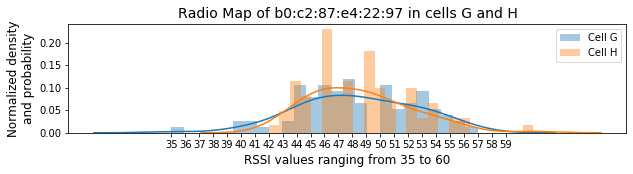

In [291]:
## Radio map of distributions of same AP that are similar

start = 35
end = 60

x = np.arange(start,end,step=1)

f,ax = plt.subplots(figsize=(10,2))
bins = np.linspace(start, 60, 100)
sns.distplot(samples_equal_one, bins=end-start, label='Cell G')
sns.distplot(samples_equal_two, bins=end-start, label='Cell H')

plt.legend(loc='upper right')
ax.set_xticks(RSSI_values[start:end])
ax.set_title(f"Radio Map of b0:c2:87:e4:22:97 in cells G and H",size=14)
ax.set_xlabel("RSSI values ranging from "+str(start)+" to "+str(end),size=12)
ax.set_ylabel("Normalized density\nand probability", multialignment='center', size=12)
plt.show()

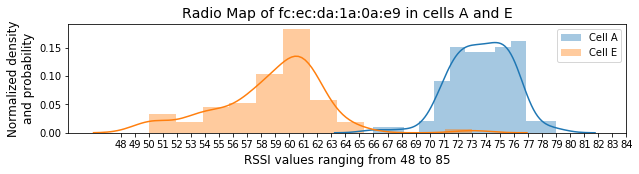

In [292]:
## Radio map of distributions of same AP that are dissimilar

start = 48
end = 85

x = np.arange(start,end,step=1)

f,ax = plt.subplots(figsize=(10,2))
bins = np.linspace(start, 60, 100)
sns.distplot(samples_non_equal_one, bins=12, label='Cell A')
sns.distplot(samples_non_equal_two, bins=12, label='Cell E')

plt.legend(loc='upper right')
ax.set_xticks(RSSI_values[start:end])
ax.set_title(f"Radio Map of fc:ec:da:1a:0a:e9 in cells A and E",size=14)
ax.set_xlabel("RSSI values ranging from "+str(start)+" to "+str(end),size=12)
ax.set_ylabel("Normalized density\nand probability", multialignment='center', size=12)
plt.show()

In [293]:
## Method that calculates the kernel at given x

def kernel(x):
    K = 1/math.sqrt(2*math.pi)*math.e**((-x**2)/2)
    return K

## Method that calculates the probability of a distribution at x
def probability(h, samples, x):
    n = len(samples)
    sum = 0
    for i in range(n):
        sum += kernel((samples[i]-x)/h)

    return 1/(n*h)*sum

In [294]:
# Calculate the probabilities for RSSI values for a set of samples
dist = list()
x_axis = np.arange(0,101,1)

std = np.std(samples_equal_one)
n = len(samples_equal_one)

h = (4*(std**5)/(3*n))**(0.2)

for i in range(len(x_axis)):
    prob = probability(h, samples_equal_one, x_axis[i])
    print(i, prob)
    dist.append(prob)

0 1.3238092775226773e-81
1 3.3985586071389686e-77
2 6.50059936691834e-73
3 9.264059446928042e-69
4 9.836453871497248e-65
5 7.78153151126386e-61
6 4.5864946967358044e-57
7 2.0141230762349075e-53
8 6.589924050011831e-50
9 1.6064385140614242e-46
10 2.917676252059733e-43
11 3.948202214296937e-40
12 3.980622278915723e-37
13 2.9901422215139564e-34
14 1.6734857390279285e-31
15 6.978168958757965e-29
16 2.167954882372289e-26
17 5.018203781946598e-24
18 8.654373642219163e-22
19 1.1120191949547107e-19
20 1.0645797982632734e-17
21 7.593350587472305e-16
22 4.035319978321849e-14
23 1.597760932784891e-12
24 4.713406690232707e-11
25 1.0359703591094049e-09
26 1.696481246980856e-08
27 2.069856292614243e-07
28 1.8815729887543105e-06
29 1.2743632030274255e-05
30 6.430776580978448e-05
31 0.00024180301567645684
32 0.0006776762951107663
33 0.0014175838500059324
34 0.0022272444400798105
35 0.002702678010202316
36 0.002828162835024868
37 0.0033576062856581703
38 0.005343856449037811
39 0.00923235793241749
40 0